In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load Titanic dataset and display basic information
data = pd.read_csv("titanic.csv")
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [21]:
# Define functions for data preprocessing
def preprocess_data(df):
    # Drop unnecessary columns
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
    
    # Fill missing Embarked values and drop the column
    df["Embarked"] = df["Embarked"].fillna("S")
    df = df.drop(columns=["Embarked"])
    
    # Fill missing ages
    fill_missing_ages(df)
    
    # Convert Gender to numeric
    df["Sex"] = df["Sex"].map({'male': 1, "female": 0})
    
    # Create new features: FamilySize, IsAlone, FareBin, AgeBin
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0, 12, 20, 40, 60, np.inf], labels=False)
    
    return df

def fill_missing_ages(df):
    # Fill missing ages based on median age of each Pclass
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()
    
    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)

In [22]:
# Apply preprocessing to the dataset
data = preprocess_data(data)

In [23]:
# Create features (X) and target (y)
X = data.drop(columns=["Survived"])
y = data["Survived"]

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Define function for hyperparameter tuning with GridSearchCV
def tune_model(X_train, y_train):
    param_grid = {
        "n_neighbors": range(1, 21),  # Test different numbers of neighbors
        "metric": ["euclidean", "manhattan", "minkowski"],  # Test distance metrics
        "weights": ["uniform", "distance"]  # Test weight strategies
    }
    
    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)  # Perform grid search
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_  # Return the best model

In [27]:
# Get the best KNN model using hyperparameter tuning
best_model = tune_model(X_train, y_train)

In [28]:
# Define function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    prediction = model.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, prediction)  # Calculate accuracy
    matrix = confusion_matrix(y_test, prediction)  # Generate confusion matrix
    return accuracy, matrix

In [29]:
# Evaluate the best model
accuracy, matrix = evaluate_model(best_model, X_test, y_test)

In [30]:
# Print accuracy and confusion matrix
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:')
print(matrix)

Accuracy: 80.27%
Confusion Matrix:
[[115  19]
 [ 25  64]]


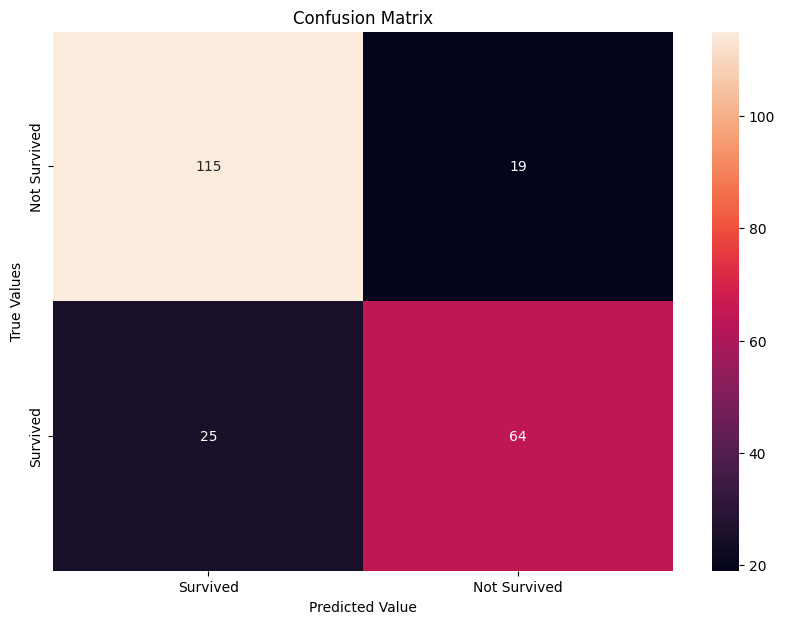

In [31]:
# Define function to plot confusion matrix
def plot_model(matrix):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Survived", "Not Survived"], yticklabels=["Not Survived", "Survived"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Values")
    plt.show()

# Plot the confusion matrix
plot_model(matrix)